In [1]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification

# Define the model architecture (based on what you know about the model)
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-uncased', num_labels=2)

# Load the weights from the .bin file
weights_path = '/home/jovyan/sentiment/all_models/bert_uncased.bin'  # Update with the path to your .bin file
model.load_state_dict(torch.load(weights_path, map_location=torch.device('cpu')))

# Save the complete model (including config)
model_save_path = 'BERT_UNCASED'
model.save_pretrained(model_save_path)

# Also save the tokenizer (assuming it's the same as used in training)
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')
tokenizer.save_pretrained(model_save_path)


A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

('BERT_UNCASED/tokenizer_config.json',
 'BERT_UNCASED/special_tokens_map.json',
 'BERT_UNCASED/vocab.txt',
 'BERT_UNCASED/added_tokens.json')

In [1]:
import torch
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import re

# Function to remove HTML tags
def remove_html_tags(text):
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

# Function to normalize text
def normalize_text(text):
    text = re.sub(r'[\u0617-\u061A\u064B-\u0652]', '', text)
    text = text.replace('ۀ', 'ہ').replace('ۂ', 'ہ').replace('ؤ', 'و').replace('ئ', 'ی')
    return text

# Custom Dataset class
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Load the pre-trained model and tokenizer
model_path = '/home/jovyan/sentiment/BERT_UNCASED' # Update with the path to your model directory
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')
model = BertForSequenceClassification.from_pretrained(model_path)
model.eval()

# Device configuration
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Load and preprocess the test dataset
test_data = pd.read_csv('/home/jovyan/sentiment/test_dataset.csv')  # Update with the path to your test dataset
test_data['Tweets'] = test_data['Tweets'].apply(remove_html_tags).apply(normalize_text)

# Define the test dataset and DataLoader
MAX_LEN = 128
BATCH_SIZE = 16
test_dataset = TweetDataset(test_data['Tweets'].tolist(), test_data['label'].tolist(), tokenizer, MAX_LEN)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Evaluation function
def eval_model(model, data_loader, device):
    model.eval()
    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())

    accuracy = accuracy_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels)
    recall = recall_score(true_labels, pred_labels)
    f1 = f1_score(true_labels, pred_labels)
    
    return accuracy, precision, recall, f1

# Evaluate the model on the test set
accuracy, precision, recall, f1 = eval_model(model, test_loader, device)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


Accuracy: 0.7294361096740818
Precision: 0.6981308411214954
Recall: 0.7888067581837381
F1 Score: 0.7407040158651462


In [1]:
import pandas as pd
import re
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import numpy as np

# Custom list of Urdu stopwords
urdu_stopwords = set([
    'اور', 'کے', 'میں', 'سے', 'کو', 'پر', 'ہے', 'کی', 'کہ', 'یہ', 'جو', 'بھی', 'کا', 'نے', 'گا', 'کر',
    'ہیں', 'ایک', 'سب', 'تو', 'وہ', 'تم', 'جب', 'ہم', 'یا', 'نہیں', 'وہاں', 'تھا', 'تھی', 'تھے', 'اگر',
    'یہاں', 'ہوں', 'رہا', 'گئی', 'تھا', 'تھی', 'تھے'
])

# Load the dataset
data = pd.read_csv('/home/jovyan/sentiment/train_dataset.csv')

# Remove HTML tags
def remove_html_tags(text):
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

data['Tweets'] = data['Tweets'].apply(remove_html_tags)

# Handle missing values and remove duplicates
data.dropna(subset=['Tweets'], inplace=True)
data.drop_duplicates(subset=['Tweets'], inplace=True)

# Normalize text
def normalize_text(text):
    text = re.sub(r'[\u0617-\u061A\u064B-\u0652]', '', text)
    text = text.replace('ۀ', 'ہ').replace('ۂ', 'ہ').replace('ؤ', 'و').replace('ئ', 'ی')
    return text

data['Tweets'] = data['Tweets'].apply(normalize_text)

# Remove stop words using the custom list of Urdu stopwords
data['cleaned_text'] = data['Tweets'].apply(lambda x: ' '.join([word for word in x.split() if word not in urdu_stopwords]))

# Split the dataset into train and validation sets (80% train, 20% validation)
X_train, X_test, y_train, y_test = train_test_split(data['cleaned_text'], data['label'], test_size=0.2, random_state=42)

### BERT Training

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')

# Define the dataset class
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Parameters
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 5
LEARNING_RATE = 2e-5

# Create DataLoader
train_dataset = TweetDataset(X_train.tolist(), y_train.tolist(), tokenizer, MAX_LEN)
val_dataset = TweetDataset(X_test.tolist(), y_test.tolist(), tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-uncased', num_labels=2)
model = model.to(device)

# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

loss_fn = torch.nn.CrossEntropyLoss().to(device)

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())
            
            true_labels.extend(labels.cpu().numpy())
            pred_labels.extend(preds.cpu().numpy())

    accuracy = accuracy_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels)
    recall = recall_score(true_labels, pred_labels)
    f1 = f1_score(true_labels, pred_labels)
    
    return accuracy, precision, recall, f1, np.mean(losses)

# Training loop
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(train_dataset)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_precision, val_recall, val_f1, val_loss = eval_model(
        model,
        val_loader,
        loss_fn,
        device,
        len(val_dataset)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc} precision {val_precision} recall {val_recall} f1 {val_f1}')
    print()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5
----------
Train loss 0.6485921107135305 accuracy 0.6022207707380797
Val   loss 0.5806266407792767 accuracy 0.7073807968647943 precision 0.6924829157175398 recall 0.7735368956743003 f1 0.7307692307692307

Epoch 2/5
----------
Train loss 0.5231785705755647 accuracy 0.7400391900718485
Val   loss 0.5064611177270611 accuracy 0.751796211626388 precision 0.7796143250688705 recall 0.7201017811704835 f1 0.7486772486772487

Epoch 3/5
----------
Train loss 0.40190423435626393 accuracy 0.8247877204441542
Val   loss 0.5184293209264675 accuracy 0.7629000653167864 precision 0.7508896797153025 recall 0.8053435114503816 f1 0.7771639042357275

Epoch 4/5
----------
Train loss 0.2713784673312003 accuracy 0.89157413455258
Val   loss 0.6119728394163152 accuracy 0.7452645329849772 precision 0.7391304347826086 recall 0.7786259541984732 f1 0.758364312267658

Epoch 5/5
----------
Train loss 0.17422273920912187 accuracy 0.9374591770084912
Val   loss 0.7281095906315992 accuracy 0.752449379490529 precis

In [2]:
# Save the model after training
model_save_path = "bert_uncased.bin"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to bert_uncased.bin


In [1]:
import pandas as pd
import re

!pip install transformers pandas torch nltk matplotlib numpy joblib


import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import numpy as np
import string
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, Dataset
import torch

# Custom list of Urdu stopwords
urdu_stopwords = set([
    'اور', 'کے', 'میں', 'سے', 'کو', 'پر', 'ہے', 'کی', 'کہ', 'یہ', 'جو', 'بھی', 'کا', 'نے', 'گا', 'کر',
    'ہیں', 'ایک', 'سب', 'تو', 'وہ', 'تم', 'جب', 'ہم', 'یا', 'نہیں', 'وہاں', 'تھا', 'تھی', 'تھے', 'اگر',
    'یہاں', 'ہوں', 'رہا', 'گئی', 'تھا', 'تھی', 'تھے'
])

# Load the dataset
data = pd.read_csv('/home/jovyan/sentiment/train_dataset.csv')

# Remove HTML tags
def remove_html_tags(text):
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

data['Tweets'] = data['Tweets'].apply(remove_html_tags)

# Handle missing values and remove duplicates
data.dropna(subset=['Tweets'], inplace=True)
data.drop_duplicates(subset=['Tweets'], inplace=True)

# Normalize text
def normalize_text(text):
    text = re.sub(r'[\u0617-\u061A\u064B-\u0652]', '', text)
    text = text.replace('ۀ', 'ہ').replace('ۂ', 'ہ').replace('ؤ', 'و').replace('ئ', 'ی')
    return text

data['Tweets'] = data['Tweets'].apply(normalize_text)

# Remove stop words using the custom list of Urdu stopwords
data['cleaned_text'] = data['Tweets'].apply(lambda x: ' '.join([word for word in x.split() if word not in urdu_stopwords]))

# Split the dataset into train and validation sets (80% train, 20% validation)
X_train, X_test, y_train, y_test = train_test_split(data['cleaned_text'], data['label'], test_size=0.2, random_state=42)

### BERT Training

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')

# Define the dataset class
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Parameters
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 3
LEARNING_RATE = 1e-5

# Create DataLoader
train_dataset = TweetDataset(X_train.tolist(), y_train.tolist(), tokenizer, MAX_LEN)
val_dataset = TweetDataset(X_test.tolist(), y_test.tolist(), tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-uncased', num_labels=2)
model = model.to(device)

# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

loss_fn = torch.nn.CrossEntropyLoss().to(device)

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

# Training loop
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(train_dataset)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_loader,
        loss_fn,
        device,
        len(val_dataset)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

/opt/conda/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/conda/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


/opt/conda/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3
----------
Train loss 0.6404742965032164 accuracy 0.6237753102547355
Val   loss 0.5553842149674892 accuracy 0.7276290006531679

Epoch 2/3
----------
Train loss 0.5190937705435267 accuracy 0.7472240365774004
Val   loss 0.5144947301596403 accuracy 0.7400391900718485

Epoch 3/3
----------
Train loss 0.431293327565604 accuracy 0.8038863487916394
Val   loss 0.5229693711735308 accuracy 0.751796211626388



In [2]:
import pandas as pd
import re

!pip install transformers pandas torch nltk matplotlib numpy joblib


import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import numpy as np
import string
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, Dataset
import torch

# Custom list of Urdu stopwords
urdu_stopwords = set([
    'اور', 'کے', 'میں', 'سے', 'کو', 'پر', 'ہے', 'کی', 'کہ', 'یہ', 'جو', 'بھی', 'کا', 'نے', 'گا', 'کر',
    'ہیں', 'ایک', 'سب', 'تو', 'وہ', 'تم', 'جب', 'ہم', 'یا', 'نہیں', 'وہاں', 'تھا', 'تھی', 'تھے', 'اگر',
    'یہاں', 'ہوں', 'رہا', 'گئی', 'تھا', 'تھی', 'تھے'
])

# Load the dataset
data = pd.read_csv('/home/jovyan/sentiment/train_dataset.csv')

# Remove HTML tags
def remove_html_tags(text):
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

data['Tweets'] = data['Tweets'].apply(remove_html_tags)

# Handle missing values and remove duplicates
data.dropna(subset=['Tweets'], inplace=True)
data.drop_duplicates(subset=['Tweets'], inplace=True)

# Normalize text
def normalize_text(text):
    text = re.sub(r'[\u0617-\u061A\u064B-\u0652]', '', text)
    text = text.replace('ۀ', 'ہ').replace('ۂ', 'ہ').replace('ؤ', 'و').replace('ئ', 'ی')
    return text

data['Tweets'] = data['Tweets'].apply(normalize_text)

# Remove stop words using the custom list of Urdu stopwords
data['cleaned_text'] = data['Tweets'].apply(lambda x: ' '.join([word for word in x.split() if word not in urdu_stopwords]))

# Split the dataset into train and validation sets (80% train, 20% validation)
X_train, X_test, y_train, y_test = train_test_split(data['cleaned_text'], data['label'], test_size=0.2, random_state=42)

### BERT Training

# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')

# Define the dataset class
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Parameters
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 3
LEARNING_RATE = 2e-5

# Create DataLoader
train_dataset = TweetDataset(X_train.tolist(), y_train.tolist(), tokenizer, MAX_LEN)
val_dataset = TweetDataset(X_test.tolist(), y_test.tolist(), tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-uncased', num_labels=2)
model = model.to(device)

# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

loss_fn = torch.nn.CrossEntropyLoss().to(device)

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

# Training loop
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(train_dataset)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_loader,
        loss_fn,
        device,
        len(val_dataset)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3
----------
Train loss 0.6507572036810394 accuracy 0.5978118876551274
Val   loss 0.5644476022571325 accuracy 0.7106466361854997

Epoch 2/3
----------
Train loss 0.5051053330963647 accuracy 0.7486936642717179
Val   loss 0.5236083520576358 accuracy 0.7413455258001307

Epoch 3/3
----------
Train loss 0.37998416510169875 accuracy 0.8337687785760941
Val   loss 0.5444485292149087 accuracy 0.7615937295885042



In [1]:
!pip install transformers pandas torch


In [2]:
import pandas as pd
import os

# Load the dataset
df = pd.read_csv('/home/jovyan/sentiment/train_dataset.csv')
df.head()


,label,Tweets
0,1,مصروف فلپس ایک کارکردگی، مزاحیہ اور ڈرامائی دو...
1,0,ایک comely آہستہ ہپپی (Kay کے لینز) اور ان کے ...
2,0,"الزبتھ وارڈ Gracen، شاید صرف بل کلنٹن کی ""Bimb..."
3,1,ایک مقبول کھیل کے طور پر، سرفنگ بہت سے لوگوں ک...
4,1,"ایڈورڈ Dmytryk کی ""فائرنگ"" ایک نایاب فلم 1940s..."


In [3]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from transformers import AdamW, get_linear_schedule_with_warmup
import numpy as np
import pandas as pd

# Load the dataset
df = pd.read_csv('/home/jovyan/sentiment/train_dataset.csv')

# Load the pre-trained BERT model and tokenizer
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define the dataset class
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Parameters
MAX_LEN = 128
BATCH_SIZE = 16
EPOCHS = 15
LEARNING_RATE = 1e-5

# Split the dataset into train and validation sets (80% train, 20% validation)
train_texts, val_texts, train_labels, val_labels = train_test_split(df['Tweets'], df['label'], test_size=0.2, random_state=42)

# Reset index to avoid KeyError issues
train_texts = train_texts.reset_index(drop=True)
val_texts = val_texts.reset_index(drop=True)
train_labels = train_labels.reset_index(drop=True)
val_labels = val_labels.reset_index(drop=True)

# Create DataLoader
train_dataset = TweetDataset(train_texts, train_labels, tokenizer, MAX_LEN)
val_dataset = TweetDataset(val_texts, val_labels, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Define optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, correct_bias=False)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Define loss function
loss_fn = torch.nn.CrossEntropyLoss().to(device)

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(train_texts)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_loader,
        loss_fn,
        device,
        len(val_texts)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

# Save the trained model and tokenizer
model.save_pretrained('bert_multilingual_uncased')
tokenizer.save_pretrained('new_tokenizer_bert_multilingual_uncased')


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.9/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/15
----------
Train loss 0.6957376122785112 accuracy 0.5061949788066514
Val   loss 0.6883582007139921 accuracy 0.5560625814863103

Epoch 2/15
----------
Train loss 0.6441861291726431 accuracy 0.6139550048907727
Val   loss 0.6050104703754187 accuracy 0.6753585397653195

Epoch 3/15
----------
Train loss 0.5547077594480166 accuracy 0.7184545158134985
Val   loss 0.5474456682180365 accuracy 0.7183833116036505

Epoch 4/15
----------
Train loss 0.47093509960298735 accuracy 0.7823606129768503
Val   loss 0.5485342643223703 accuracy 0.7157757496740548

Epoch 5/15
----------
Train loss 0.37518772133626044 accuracy 0.8392566025432018
Val   loss 0.6039051292464137 accuracy 0.7209908735332464

Epoch 6/15
----------
Train loss 0.2767818596039433 accuracy 0.8881643299641343
Val   loss 0.6886104225801924 accuracy 0.7301173402868318

Epoch 7/15
----------
Train loss 0.20357070164997518 accuracy 0.9271274861428106
Val   loss 0.8056215747880439 accuracy 0.7203389830508474

Epoch 8/15
----------
Tr

('new_tokenizer_bert_multilingual_uncased/tokenizer_config.json',
 'new_tokenizer_bert_multilingual_uncased/special_tokens_map.json',
 'new_tokenizer_bert_multilingual_uncased/vocab.txt',
 'new_tokenizer_bert_multilingual_uncased/added_tokens.json')

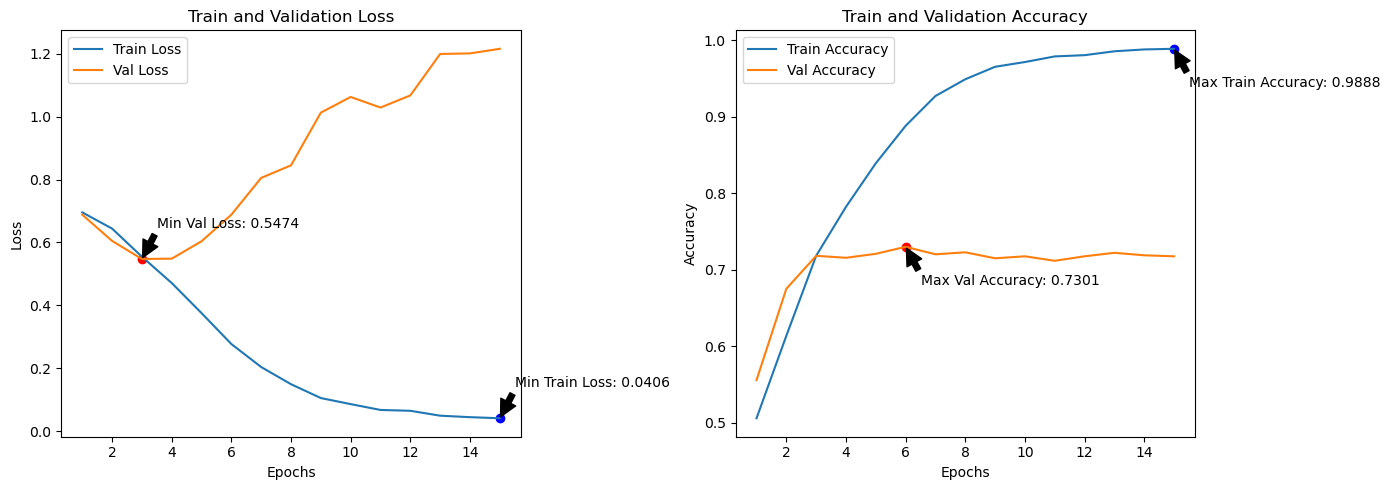

In [4]:
import matplotlib.pyplot as plt

# Given data
epochs = list(range(1, 16))
train_losses = [
    0.6957376122785112, 0.6441861291726431, 0.5547077594480166, 0.47093509960298735,
    0.37518772133626044, 0.2767818596039433, 0.20357070164997518, 0.1489520680673498,
    0.10488639461497466, 0.08562327845599309, 0.06707148534284595, 0.06436189331604207,
    0.048810995620442554, 0.04407795266767304, 0.04064318265166852
]
val_losses = [
    0.6883582007139921, 0.6050104703754187, 0.5474456682180365, 0.5485342643223703,
    0.6039051292464137, 0.6886104225801924, 0.8056215747880439, 0.8455992011586204,
    1.0133392323429387, 1.0631559870477456, 1.0294332119325798, 1.0680428315342094,
    1.199930739249491, 1.2017339244387888, 1.2163838805960647
]
train_accuracies = [
    0.5061949788066514, 0.6139550048907727, 0.7184545158134985, 0.7823606129768503,
    0.8392566025432018, 0.8881643299641343, 0.9271274861428106, 0.9489729377241604,
    0.9652755135311379, 0.9714704923377894, 0.9788066514509293, 0.980436909031627,
    0.98549070753179, 0.9879360939028367, 0.9887512226931855
]
val_accuracies = [
    0.5560625814863103, 0.6753585397653195, 0.7183833116036505, 0.7157757496740548,
    0.7209908735332464, 0.7301173402868318, 0.7203389830508474, 0.7229465449804433,
    0.7151238591916558, 0.7177314211212517, 0.711864406779661, 0.7177314211212517,
    0.7222946544980443, 0.7190352020860495, 0.7177314211212517
]

# Plotting
plt.figure(figsize=(14, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.scatter(epochs[val_losses.index(min(val_losses))], min(val_losses), color='red')  # Min Val Loss
plt.scatter(epochs[train_losses.index(min(train_losses))], min(train_losses), color='blue')  # Min Train Loss
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.annotate(f'Min Val Loss: {min(val_losses):.4f}', xy=(epochs[val_losses.index(min(val_losses))], min(val_losses)),
             xytext=(epochs[val_losses.index(min(val_losses))] + 0.5, min(val_losses) + 0.1),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate(f'Min Train Loss: {min(train_losses):.4f}', xy=(epochs[train_losses.index(min(train_losses))], min(train_losses)),
             xytext=(epochs[train_losses.index(min(train_losses))] + 0.5, min(train_losses) + 0.1),
             arrowprops=dict(facecolor='black', shrink=0.05))

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Val Accuracy')
plt.scatter(epochs[val_accuracies.index(max(val_accuracies))], max(val_accuracies), color='red')  # Max Val Accuracy
plt.scatter(epochs[train_accuracies.index(max(train_accuracies))], max(train_accuracies), color='blue')  # Max Train Accuracy
plt.title('Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.annotate(f'Max Val Accuracy: {max(val_accuracies):.4f}', xy=(epochs[val_accuracies.index(max(val_accuracies))], max(val_accuracies)),
             xytext=(epochs[val_accuracies.index(max(val_accuracies))] + 0.5, max(val_accuracies) - 0.05),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate(f'Max Train Accuracy: {max(train_accuracies):.4f}', xy=(epochs[train_accuracies.index(max(train_accuracies))], max(train_accuracies)),
             xytext=(epochs[train_accuracies.index(max(train_accuracies))] + 0.5, max(train_accuracies) - 0.05),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a DataFrame with the provided data
data = {
    'Epoch': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    'Train Loss': [0.696986, 0.695307, 0.695242, 0.686989, 0.650574, 0.604535, 0.572391, 0.542487, 0.513000, 0.487396, 0.454077, 0.422632, 0.393964, 0.378080, 0.359264],
    'Val Loss': [0.691668, 0.704437, 0.697999, 0.674897, 0.647810, 0.606982, 0.601664, 0.605869, 0.611557, 0.604137, 0.608957, 0.607929, 0.646320, 0.643958, 0.652987],
    'Train Accuracy': [0.509782, 0.506032, 0.502608, 0.549886, 0.617052, 0.677698, 0.704271, 0.733127, 0.753668, 0.768829, 0.792142, 0.815455, 0.827030, 0.838768, 0.851321],
    'Val Accuracy': [0.514342, 0.514342, 0.485658, 0.583442, 0.626467, 0.677314, 0.677314, 0.675359, 0.704042, 0.704694, 0.711864, 0.709257, 0.708605, 0.710561, 0.710561]
}

df = pd.DataFrame(data)

# Plotting the results
epochs = df['Epoch']

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, df['Train Loss'], label='Train Loss')
plt.plot(epochs, df['Val Loss'], label='Val Loss')
plt.scatter(epochs[df['Val Loss'].idxmin()], df['Val Loss'].min(), color='blue')  # Min Val Loss
plt.scatter(epochs[df['Train Loss'].idxmin()], df['Train Loss'].min(), color='red')  # Min Train Loss
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.annotate(f'Min Train Loss: {df["Train Loss"].min():.4f}', xy=(epochs[df['Train Loss'].idxmin()], df['Train Loss'].min()), xytext=(epochs[df['Train Loss'].idxmin()], df['Train Loss'].min() + 0.05), arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate(f'Min Val Loss: {df["Val Loss"].min():.4f}', xy=(epochs[df['Val Loss'].idxmin()], df['Val Loss'].min()), xytext=(epochs[df['Val Loss'].idxmin()], df['Val Loss'].min() + 0.05), arrowprops=dict(facecolor='black', shrink=0.05))

plt.subplot(1, 2, 2)
plt.plot(epochs, df['Train Accuracy'], label='Train Accuracy')
plt.plot(epochs, df['Val Accuracy'], label='Val Accuracy')
plt.scatter(epochs[df['Val Accuracy'].idxmax()], df['Val Accuracy'].max(), color='blue')  # Max Val Accuracy
plt.scatter(epochs[df['Train Accuracy'].idxmax()], df['Train Accuracy'].max(), color='red')  # Max Train Accuracy
plt.title('Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.annotate(f'Max Train Accuracy: {df["Train Accuracy"].max():.4f}', xy=(epochs[df['Train Accuracy'].idxmax()], df['Train Accuracy'].max()), xytext=(epochs[df['Train Accuracy'].idxmax()], df['Train Accuracy'].max() - 0.05), arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate(f'Max Val Accuracy: {df["Val Accuracy"].max():.4f}', xy=(epochs[df['Val Accuracy'].idxmax()], df['Val Accuracy'].max()), xytext=(epochs[df['Val Accuracy'].idxmax()], df['Val Accuracy'].max() - 0.05), arrowprops=dict(facecolor='black', shrink=0.05))

plt.tight_layout()
plt.show()


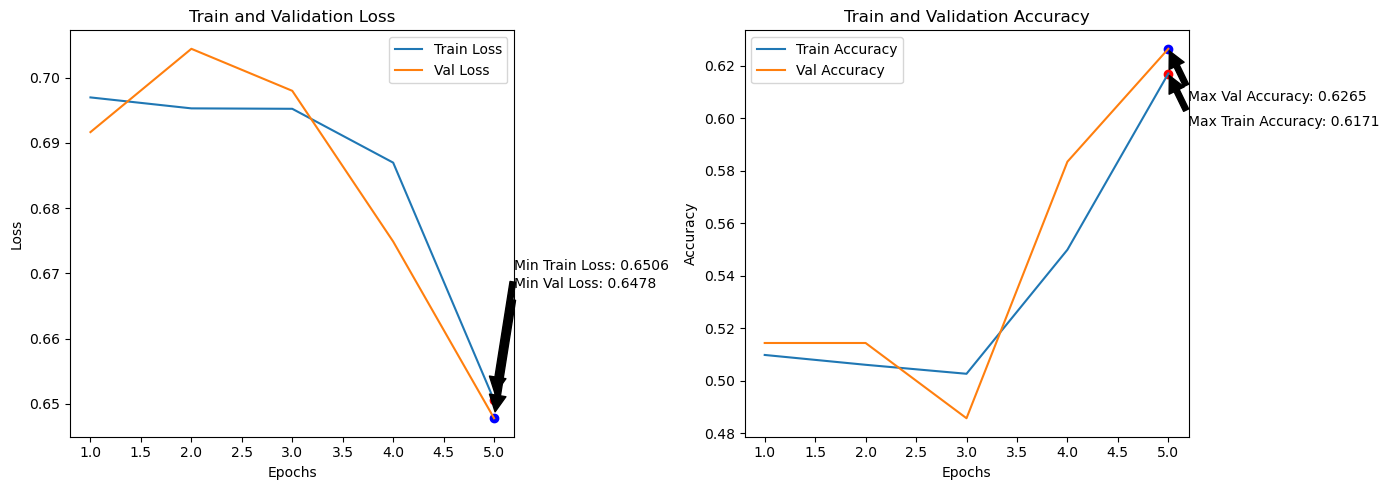

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a DataFrame with the provided data up to epoch 5
data = {
    'Epoch': [1, 2, 3, 4, 5],
    'Train Loss': [0.696986, 0.695307, 0.695242, 0.686989, 0.650574],
    'Val Loss': [0.691668, 0.704437, 0.697999, 0.674897, 0.647810],
    'Train Accuracy': [0.509782, 0.506032, 0.502608, 0.549886, 0.617052],
    'Val Accuracy': [0.514342, 0.514342, 0.485658, 0.583442, 0.626467]
}

df = pd.DataFrame(data)

# Plotting the results
epochs = df['Epoch']

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, df['Train Loss'], label='Train Loss')
plt.plot(epochs, df['Val Loss'], label='Val Loss')
plt.scatter(epochs[df['Val Loss'].idxmin()], df['Val Loss'].min(), color='blue')  # Min Val Loss
plt.scatter(epochs[df['Train Loss'].idxmin()], df['Train Loss'].min(), color='red')  # Min Train Loss
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.annotate(f'Min Train Loss: {df["Train Loss"].min():.4f}', xy=(epochs[df['Train Loss'].idxmin()], df['Train Loss'].min()), xytext=(epochs[df['Train Loss'].idxmin()] + 0.2, df['Train Loss'].min() + 0.02), arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate(f'Min Val Loss: {df["Val Loss"].min():.4f}', xy=(epochs[df['Val Loss'].idxmin()], df['Val Loss'].min()), xytext=(epochs[df['Val Loss'].idxmin()] + 0.2, df['Val Loss'].min() + 0.02), arrowprops=dict(facecolor='black', shrink=0.05))

plt.subplot(1, 2, 2)
plt.plot(epochs, df['Train Accuracy'], label='Train Accuracy')
plt.plot(epochs, df['Val Accuracy'], label='Val Accuracy')
plt.scatter(epochs[df['Val Accuracy'].idxmax()], df['Val Accuracy'].max(), color='blue')  # Max Val Accuracy
plt.scatter(epochs[df['Train Accuracy'].idxmax()], df['Train Accuracy'].max(), color='red')  # Max Train Accuracy
plt.title('Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.annotate(f'Max Train Accuracy: {df["Train Accuracy"].max():.4f}', xy=(epochs[df['Train Accuracy'].idxmax()], df['Train Accuracy'].max()), xytext=(epochs[df['Train Accuracy'].idxmax()] + 0.2, df['Train Accuracy'].max() - 0.02), arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate(f'Max Val Accuracy: {df["Val Accuracy"].max():.4f}', xy=(epochs[df['Val Accuracy'].idxmax()], df['Val Accuracy'].max()), xytext=(epochs[df['Val Accuracy'].idxmax()] + 0.2, df['Val Accuracy'].max() - 0.02), arrowprops=dict(facecolor='black', shrink=0.05))

plt.tight_layout()
plt.show()
